# Graph RAG

## Setting Up the Environment

In [43]:
import numpy as np
import json
import fitz 
from typing import List, Dict, Tuple, Any
import networkx as nx
import matplotlib.pyplot as plt
import heapq
from collections import defaultdict
import re
from PIL import Image
import io

In [44]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumGothicOTF') # For MacOS
plt.rc('font', family='NanumGothic') # For Windows
%matplotlib inline

In [45]:
from openai import OpenAI
from dotenv import load_dotenv
import os

load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

## Document Processing Functions

In [46]:
def extract_text_from_pdf(pdf_path):
    """
    PDF 파일에서 텍스트 내용을 추출합니다.

    Args:
        pdf_path (str): PDF 파일 경로

    Returns:
        str: 추출된 텍스트 내용
    """
    print(f"{pdf_path}에서 텍스트를 추출하는 중...")  # 처리 중인 PDF 경로 출력
    pdf_document = fitz.open(pdf_path)  # PyMuPDF를 사용해 PDF 파일 열기
    text = ""  # 추출된 텍스트를 저장할 빈 문자열 초기화

    # PDF의 각 페이지를 순회하면서 텍스트 추출
    for page_num in range(pdf_document.page_count):
        page = pdf_document[page_num]  # 페이지 객체 가져오기
        text += page.get_text()  # 해당 페이지에서 텍스트 추출 후 누적

    return text  # 최종 추출된 텍스트 반환

In [47]:
def chunk_text(text, chunk_size=1000, overlap=200):
    """
    텍스트를 일정 길이의 겹치는 청크로 나눕니다.

    Args:
        text (str): 청크로 분할할 원본 텍스트
        chunk_size (int): 각 청크의 길이 (문자 단위)
        overlap (int): 청크 간 중첩 길이 (문자 단위)

    Returns:
        List[Dict]: 각 청크와 메타데이터를 포함한 리스트
    """
    chunks = []  # 청크를 저장할 빈 리스트 초기화

    # (chunk_size - overlap)만큼 이동하며 텍스트를 순회
    for i in range(0, len(text), chunk_size - overlap):
        # 현재 위치에서 chunk_size만큼 텍스트 추출
        chunk_text = text[i:i + chunk_size]
        
        # 빈 청크는 제외
        if chunk_text:
            # 텍스트 조각과 관련 메타데이터를 리스트에 추가
            chunks.append({
                "text": chunk_text,          # 청크 텍스트
                "index": len(chunks),        # 청크 인덱스
                "start_pos": i,              # 원본 텍스트에서 시작 위치
                "end_pos": i + len(chunk_text)  # 원본 텍스트에서 종료 위치
            })
    
    # 생성된 청크 수 출력
    print(f"{len(chunks)}개의 텍스트 청크가 생성되었습니다.")
    
    return chunks  # 청크 리스트 반환

## Creating Embeddings

In [48]:
def create_embeddings(texts, model="text-embedding-3-small"):
    """
    주어진 텍스트들에 대해 임베딩 벡터를 생성합니다.

    Args:
        texts (List[str]): 임베딩을 생성할 입력 텍스트 목록
        model (str): 사용할 임베딩 모델 이름

    Returns:
        List[List[float]]: 생성된 임베딩 벡터 목록
    """
    # 입력이 비어 있는 경우 빈 리스트 반환
    if not texts:
        return []
        
    # 배치 단위로 처리 (예: OpenAI API 제한 등 고려)
    batch_size = 100
    all_embeddings = []  # 전체 임베딩 결과 저장 리스트
    
    # 입력 텍스트들을 배치 단위로 순회
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i + batch_size]  # 현재 배치 구성
        
        # 현재 배치에 대해 임베딩 생성 요청
        response = client.embeddings.create(
            model=model,
            input=batch
        )
        
        # 응답에서 임베딩 벡터 추출
        batch_embeddings = [item.embedding for item in response.data]
        all_embeddings.extend(batch_embeddings)  # 전체 임베딩 결과에 추가
    
    return all_embeddings  # 전체 임베딩 벡터 반환

## Knowledge Graph Construction

In [49]:
def extract_concepts(text):
    """
    주어진 텍스트에서 핵심 개념을 추출합니다 (OpenAI API 사용).

    Args:
        text (str): 개념을 추출할 입력 텍스트

    Returns:
        List[str]: 추출된 핵심 개념 리스트
    """
    # 모델에게 수행할 작업을 명시하는 시스템 메시지
    system_message = """주어진 텍스트에서 핵심 개념과 주요 엔티티를 추출하세요.
    텍스트에서 가장 중요한 5~10개의 키워드, 개념, 또는 엔티티만 리스트로 출력하세요.
    반환 형식은 JSON 문자열 배열(JSON array of strings)로 하세요."""

    # OpenAI API 호출
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_message},
            {"role": "user", "content": f"다음 텍스트에서 핵심 개념을 추출하세요:\n\n{text[:3000]}"}  # API 입력 길이 제한
        ],
        temperature=0.0,
        response_format={"type": "json_object"}  # 응답 형식을 JSON으로 요청
    )
    
    try:
        # 응답에서 개념 정보 파싱
        concepts_json = json.loads(response.choices[0].message.content)
        concepts = concepts_json.get("concepts", [])
        
        # "concepts" 키가 없을 경우, 응답에서 리스트 형태 항목 추출 시도
        if not concepts and "concepts" not in concepts_json:
            for key, value in concepts_json.items():
                if isinstance(value, list):
                    concepts = value
                    break
        return concepts
    
    except (json.JSONDecodeError, AttributeError):
        # JSON 파싱 실패 시 예외 처리
        content = response.choices[0].message.content
        # 대괄호([])로 된 리스트 형태 텍스트 추출
        matches = re.findall(r'\[(.*?)\]', content, re.DOTALL)
        if matches:
            items = re.findall(r'"([^"]*)"', matches[0])
            return items
        return []

In [50]:
def build_knowledge_graph(chunks):
    """
    텍스트 청크로부터 지식 그래프를 생성합니다.

    Args:
        chunks (List[Dict]): 메타데이터가 포함된 텍스트 청크 목록

    Returns:
        Tuple[nx.Graph, List[np.ndarray]]: 생성된 지식 그래프와 각 청크의 임베딩 벡터 목록
    """
    print("지식 그래프를 생성하는 중...")

    # 그래프 객체 생성
    graph = nx.Graph()
    
    # 각 청크에서 텍스트만 추출
    texts = [chunk["text"] for chunk in chunks]
    
    # 모든 청크에 대해 임베딩 생성
    print("청크 임베딩 생성 중...")
    embeddings = create_embeddings(texts)
    
    # 노드 추가
    print("그래프에 노드를 추가하는 중...")
    for i, chunk in enumerate(chunks):
        # 해당 청크에서 개념 추출
        print(f"청크 {i+1}/{len(chunks)} 개념 추출 중...")
        concepts = extract_concepts(chunk["text"])
        
        # 노드에 텍스트, 개념, 임베딩 정보를 속성으로 추가
        graph.add_node(i, 
                       text=chunk["text"], 
                       concepts=concepts,
                       embedding=embeddings[i])
    
    # 공통 개념을 기준으로 노드 간 엣지 생성
    print("노드 간 엣지를 생성하는 중...")
    for i in range(len(chunks)):
        node_concepts = set(graph.nodes[i]["concepts"])
        
        for j in range(i + 1, len(chunks)):
            other_concepts = set(graph.nodes[j]["concepts"])
            shared_concepts = node_concepts.intersection(other_concepts)
            
            # 공통 개념이 있는 경우에만 엣지 연결
            if shared_concepts:
                # 두 청크 간 코사인 유사도 계산
                similarity = np.dot(embeddings[i], embeddings[j]) / (np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[j]))
                
                # 개념 중첩 정도 + 임베딩 유사도를 기반으로 엣지 가중치 계산
                concept_score = len(shared_concepts) / min(len(node_concepts), len(other_concepts))
                edge_weight = 0.7 * similarity + 0.3 * concept_score
                
                # 의미 있는 연관성이 있을 때만 엣지 추가
                if edge_weight > 0.6:
                    graph.add_edge(i, j, 
                                   weight=edge_weight,
                                   similarity=similarity,
                                   shared_concepts=list(shared_concepts))
    
    print(f"총 {graph.number_of_nodes()}개의 노드와 {graph.number_of_edges()}개의 엣지로 구성된 지식 그래프가 생성되었습니다.")
    return graph, embeddings

## Graph Traversal and Query Processing

In [51]:
def traverse_graph(query, graph, embeddings, top_k=5, max_depth=3):
    """
    지식 그래프를 순회하여 쿼리와 관련된 정보를 탐색합니다.

    Args:
        query (str): 사용자의 질문
        graph (nx.Graph): 지식 그래프
        embeddings (List): 각 노드의 임베딩 벡터 목록
        top_k (int): 초기 탐색 시작점으로 사용할 유사한 노드 개수
        max_depth (int): 최대 탐색 깊이

    Returns:
        List[Dict]: 그래프 탐색을 통해 수집한 관련 정보 목록
    """
    print(f"그래프를 순회하여 쿼리를 탐색 중: {query}")
    
    # 쿼리에 대한 임베딩 생성
    query_embedding = create_embeddings(query)
    
    # 쿼리와 각 노드 간의 코사인 유사도 계산
    similarities = []
    for i, node_embedding in enumerate(embeddings):
        similarity = np.dot(query_embedding, node_embedding) / (np.linalg.norm(query_embedding) * np.linalg.norm(node_embedding))
        similarities.append((i, similarity))
    
    # 유사도 기준으로 내림차순 정렬
    similarities.sort(key=lambda x: x[1], reverse=True)
    
    # 상위 top_k개의 노드를 시작점으로 설정
    starting_nodes = [node for node, _ in similarities[:top_k]]
    print(f"탐색 시작 노드: {len(starting_nodes)}개 선택됨")
    
    # 탐색 상태 초기화
    visited = set()  # 이미 방문한 노드 추적용
    traversal_path = []  # 방문 경로 저장
    results = []  # 탐색 결과 저장
    
    # 우선순위 큐를 이용한 탐색
    queue = []
    for node in starting_nodes:
        heapq.heappush(queue, (-similarities[node][1], node))  # 유사도를 기준으로 최대 힙 사용
    
    # 우선순위 기반 BFS로 그래프 순회
    while queue and len(results) < (top_k * 3):  # 최대 결과 수 제한
        _, node = heapq.heappop(queue)
        
        if node in visited:
            continue
        
        # 방문 처리
        visited.add(node)
        traversal_path.append(node)
        
        # 현재 노드의 텍스트 및 개념 정보 저장
        results.append({
            "text": graph.nodes[node]["text"],
            "concepts": graph.nodes[node]["concepts"],
            "node_id": node
        })
        
        # 최대 깊이에 도달하지 않았을 경우 이웃 노드 탐색
        if len(traversal_path) < max_depth:
            neighbors = [(neighbor, graph[node][neighbor]["weight"]) 
                         for neighbor in graph.neighbors(node)
                         if neighbor not in visited]
            
            # 엣지 가중치 기준으로 이웃 노드 큐에 추가
            for neighbor, weight in sorted(neighbors, key=lambda x: x[1], reverse=True):
                heapq.heappush(queue, (-weight, neighbor))
    
    print(f"총 {len(results)}개의 관련 청크를 탐색 완료")
    return results, traversal_path

## Response Generation

In [52]:
def generate_response(query, context_chunks):
    """
    검색된 문맥을 바탕으로 사용자 질문에 응답을 생성합니다.

    Args:
        query (str): 사용자의 질문
        context_chunks (List[Dict]): 그래프 순회로 얻은 관련 텍스트 청크들

    Returns:
        str: 생성된 응답
    """
    # 각 청크에서 텍스트만 추출
    context_texts = [chunk["text"] for chunk in context_chunks]
    
    # 추출된 텍스트를 "---" 구분자로 연결하여 하나의 문맥 문자열로 구성
    combined_context = "\n\n---\n\n".join(context_texts)
    
    # 모델 입력 제한을 고려한 최대 문맥 길이 설정
    max_context = 14000
    
    # 문맥이 제한 길이를 초과할 경우 자르기
    if len(combined_context) > max_context:
        combined_context = combined_context[:max_context] + "... [일부 생략됨]"
    
    # 시스템 메시지: AI에게 답변 방식에 대한 지침 제공
    system_message = """당신은 유용한 AI 어시스턴트입니다. 주어진 문맥을 기반으로 사용자의 질문에 답하세요.
    문맥에 정보가 없다면 모른다고 말하세요. 가능하면 문맥의 특정 내용을 참조하여 답변하세요."""

    # OpenAI API를 사용하여 응답 생성
    response = client.chat.completions.create(
        model="gpt-4o-mini",  # 사용할 모델 지정
        messages=[
            {"role": "system", "content": system_message},  # 어시스턴트에 대한 역할 지침
            {"role": "user", "content": f"문맥:\n{combined_context}\n\n질문: {query}"}  # 문맥과 질문을 함께 전달
        ],
        temperature=0.2  # 낮은 온도로 일관된 응답 유도
    )
    
    # 생성된 응답 텍스트 반환
    return response.choices[0].message.content

## Visualization

In [53]:
def visualize_graph_traversal(graph, traversal_path):
    """
    지식 그래프와 탐색 경로를 시각화합니다.

    Args:
        graph (nx.Graph): 지식 그래프
        traversal_path (List): 탐색 순서에 해당하는 노드 목록
    """
    plt.figure(figsize=(12, 10))  # 그래프 크기 설정

    # 기본 노드 색상: 연한 파란색
    node_color = ['lightblue'] * graph.number_of_nodes()
    
    # 탐색 경로에 포함된 노드는 연두색으로 표시
    for node in traversal_path:
        node_color[node] = 'lightgreen'
    
    # 시작 노드는 초록색, 마지막 노드는 빨간색으로 강조
    if traversal_path:
        node_color[traversal_path[0]] = 'green'
        node_color[traversal_path[-1]] = 'red'
    
    # spring layout을 사용하여 노드 위치 지정
    pos = nx.spring_layout(graph, k=0.5, iterations=50, seed=42)
    
    # 노드 그리기
    nx.draw_networkx_nodes(graph, pos, node_color=node_color, node_size=500, alpha=0.8)
    
    # 엣지 그리기 (가중치 비례 두께)
    for u, v, data in graph.edges(data=True):
        weight = data.get('weight', 1.0)
        nx.draw_networkx_edges(graph, pos, edgelist=[(u, v)], width=weight*2, alpha=0.6)
    
    # 탐색 경로 강조 (빨간색 점선)
    traversal_edges = [(traversal_path[i], traversal_path[i+1]) 
                       for i in range(len(traversal_path)-1)]
    
    nx.draw_networkx_edges(graph, pos, edgelist=traversal_edges, 
                           width=3, alpha=0.8, edge_color='red', 
                           style='dashed', arrows=True)
    
    # 노드 라벨 추가 (첫 번째 개념을 라벨로 표시)
    labels = {}
    for node in graph.nodes():
        concepts = graph.nodes[node]['concepts']
        label = concepts[0] if concepts else f"Node {node}"
        labels[node] = f"{node}: {label}"
    
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=8)
    
    plt.title("탐색 경로가 표시된 지식 그래프")  # 그래프 제목 설정
    plt.axis('off')  # 축 제거
    plt.tight_layout()  # 레이아웃 조정
    plt.show()  # 그래프 출력

## Complete Graph RAG Pipeline

In [54]:
def graph_rag_pipeline(pdf_path, query, chunk_size=1000, chunk_overlap=200, top_k=3):
    """
    문서부터 답변 생성까지 전체 Graph RAG 파이프라인을 실행합니다.

    Args:
        pdf_path (str): PDF 문서 경로
        query (str): 사용자 질문
        chunk_size (int): 텍스트 청크의 크기
        chunk_overlap (int): 청크 간 중첩 길이
        top_k (int): 탐색을 시작할 최상위 노드 개수

    Returns:
        Dict: 질문, 응답, 관련 청크, 탐색 경로, 그래프를 포함한 결과
    """
    # PDF 문서에서 텍스트 추출
    text = extract_text_from_pdf(pdf_path)
    
    # 추출된 텍스트를 중첩된 청크로 분할
    chunks = chunk_text(text, chunk_size, chunk_overlap)
    
    # 청크들을 기반으로 지식 그래프 생성
    graph, embeddings = build_knowledge_graph(chunks)
    
    # 그래프를 순회하여 질문과 관련된 청크 탐색
    relevant_chunks, traversal_path = traverse_graph(query, graph, embeddings, top_k)
    
    # 질문과 탐색된 청크를 바탕으로 응답 생성
    response = generate_response(query, relevant_chunks)
    
    # 탐색 경로 시각화
    visualize_graph_traversal(graph, traversal_path)
    
    # 최종 결과 반환
    return {
        "query": query,  # 사용자 질문
        "response": response,  # 생성된 응답
        "relevant_chunks": relevant_chunks,  # 관련된 텍스트 청크들
        "traversal_path": traversal_path,  # 탐색 경로
        "graph": graph  # 지식 그래프 객체
    }

## Evaluation Function

In [55]:
def evaluate_graph_rag(pdf_path, test_queries, reference_answers=None):
    """
    여러 테스트 쿼리에 대해 Graph RAG 기반 응답을 평가합니다.

    Args:
        pdf_path (str): PDF 문서 경로
        test_queries (List[str]): 테스트용 질문 목록
        reference_answers (List[str], optional): 기준 정답 목록 (선택 사항)

    Returns:
        Dict: 평가 결과 및 그래프 통계
    """
    # PDF에서 텍스트 추출
    text = extract_text_from_pdf(pdf_path)
    
    # 텍스트를 청크로 분할
    chunks = chunk_text(text)
    
    # 지식 그래프 생성 (한 번만 수행)
    graph, embeddings = build_knowledge_graph(chunks)
    
    results = []  # 전체 평가 결과 저장용
    
    for i, query in enumerate(test_queries):
        print(f"\n\n***쿼리 평가 중: {i+1}/{len(test_queries)} ===")
        print(f"질문: {query}")
        
        # 그래프를 순회하여 관련 정보 탐색
        relevant_chunks, traversal_path = traverse_graph(query, graph, embeddings)
        
        # 응답 생성
        response = generate_response(query, relevant_chunks)
        
        # 기준 정답이 있을 경우 비교 수행
        reference = None
        comparison = None
        if reference_answers and i < len(reference_answers):
            reference = reference_answers[i]
            comparison = compare_with_reference(response, reference, query)
        
        # 현재 쿼리의 평가 결과 저장
        results.append({
            "query": query,
            "response": response,
            "reference_answer": reference,
            "comparison": comparison,
            "traversal_path_length": len(traversal_path),
            "relevant_chunks_count": len(relevant_chunks)
        })
        
        # 응답 및 비교 결과 출력
        print(f"\n[응답 결과]: {response}\n")
        if comparison:
            print(f"[비교 결과]: {comparison}\n")
    
    # 전체 평가 결과 및 그래프 통계 반환
    return {
        "results": results,
        "graph_stats": {
            "nodes": graph.number_of_nodes(),
            "edges": graph.number_of_edges(),
            "avg_degree": sum(dict(graph.degree()).values()) / graph.number_of_nodes()
        }
    }

In [56]:
def compare_with_reference(response, reference, query):
    """
    생성된 응답과 기준 정답(reference)을 비교하여 분석합니다.

    Args:
        response (str): AI가 생성한 응답
        reference (str): 기준 정답
        query (str): 원래의 질문

    Returns:
        str: 비교 분석 결과
    """
    # 모델에게 비교 기준을 안내하는 시스템 메시지
    system_message = """AI가 생성한 응답과 기준 정답을 비교하세요.
    비교 기준은 정확성, 완전성, 질문과의 관련성입니다.
    생성된 응답이 기준 정답과 얼마나 잘 일치하는지 2~3문장으로 간략히 분석해 주세요."""

    # 비교를 위한 프롬프트 구성: 질문, AI 응답, 기준 정답 포함
    prompt = f"""
    질문:
    {query}

    AI가 생성한 응답:
    {response}

    기준 정답:
    {reference}

    AI의 응답이 기준 정답과 얼마나 잘 일치하나요?
    """

    # OpenAI API 호출을 통해 비교 분석 생성
    comparison = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_message},  # 비교 지침 제공
            {"role": "user", "content": prompt}  # 비교 대상 전달
        ],
        temperature=0.0  # 일관된 결과 생성을 위한 온도 설정
    )
    
    # 분석 결과 반환
    return comparison.choices[0].message.content

## Evaluation of Graph RAG on a Sample PDF Document

dataset/AI_Understanding.pdf에서 텍스트를 추출하는 중...
21개의 텍스트 청크가 생성되었습니다.
지식 그래프를 생성하는 중...
청크 임베딩 생성 중...
그래프에 노드를 추가하는 중...
청크 1/21 개념 추출 중...
청크 2/21 개념 추출 중...
청크 3/21 개념 추출 중...
청크 4/21 개념 추출 중...
청크 5/21 개념 추출 중...
청크 6/21 개념 추출 중...
청크 7/21 개념 추출 중...
청크 8/21 개념 추출 중...
청크 9/21 개념 추출 중...
청크 10/21 개념 추출 중...
청크 11/21 개념 추출 중...
청크 12/21 개념 추출 중...
청크 13/21 개념 추출 중...
청크 14/21 개념 추출 중...
청크 15/21 개념 추출 중...
청크 16/21 개념 추출 중...
청크 17/21 개념 추출 중...
청크 18/21 개념 추출 중...
청크 19/21 개념 추출 중...
청크 20/21 개념 추출 중...
청크 21/21 개념 추출 중...
노드 간 엣지를 생성하는 중...
총 21개의 노드와 5개의 엣지로 구성된 지식 그래프가 생성되었습니다.
그래프를 순회하여 쿼리를 탐색 중: 자연어 처리에서 트랜스포머의 주요 응용 분야는 무엇인가요?
탐색 시작 노드: 3개 선택됨
총 3개의 관련 청크를 탐색 완료


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/tmp/ipykernel_3600249/2863470796.py:53: UserWarning: Glyph 53456 (\N{HANGUL SYLLABLE TAM}) missing from current font.
  plt.tight_layout()  # 레이아웃 조정
/tmp/ipykernel_3600249/2863470796.py:53: UserWarning: Glyph 49353 (\N{HANGUL SYLLABLE SAEG}) missing from current font.
  plt.tight_layout()  # 레이아웃 조정
/tmp/ipykernel_3600249/2863470796.py:53: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from current font.
  plt.tight_layout()  # 레이아웃 조정
/tmp/ipykernel_3600249/2863470796.py:53: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from current font.
  plt.tight_layout()  # 레이아웃 조정
/tmp/ipykernel_3600249/2863470796.py:53: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  plt.tight_layout()  # 레이아웃 조정
/tmp/ipykernel_3600249/2863470796.py:53: UserWarning: Glyph 54364 (\N{HANGUL SYLLABLE PYO}) missing from current font.
  plt.tight_layout()  # 레이아웃 조

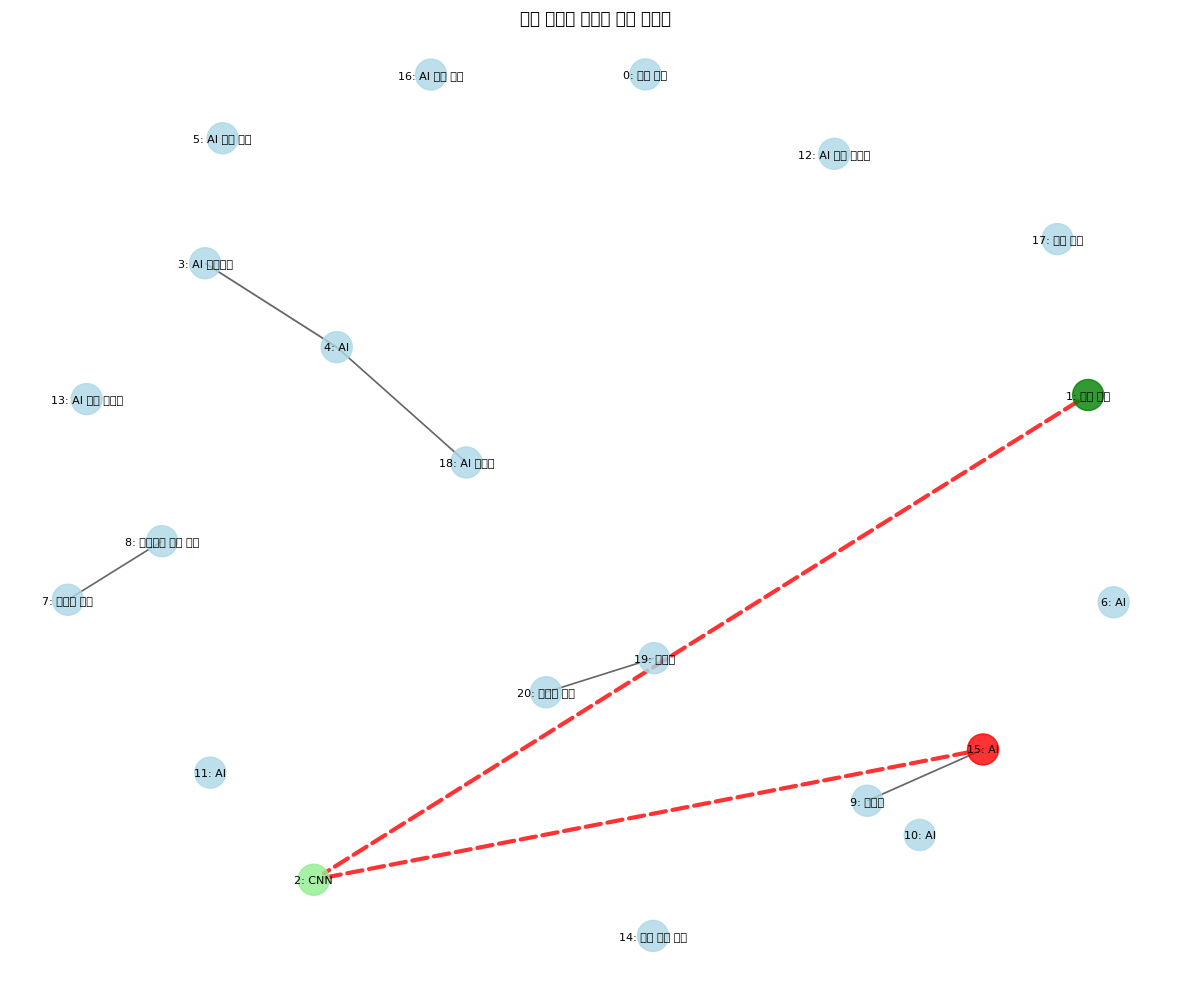


***응답 결과***
문맥에는 자연어 처리에서 트랜스포머의 주요 응용 분야에 대한 구체적인 정보가 포함되어 있지 않습니다. 따라서 이 질문에 대한 답변을 제공할 수 없습니다.
dataset/AI_Understanding.pdf에서 텍스트를 추출하는 중...
21개의 텍스트 청크가 생성되었습니다.
지식 그래프를 생성하는 중...
청크 임베딩 생성 중...
그래프에 노드를 추가하는 중...
청크 1/21 개념 추출 중...
청크 2/21 개념 추출 중...
청크 3/21 개념 추출 중...
청크 4/21 개념 추출 중...
청크 5/21 개념 추출 중...
청크 6/21 개념 추출 중...
청크 7/21 개념 추출 중...
청크 8/21 개념 추출 중...
청크 9/21 개념 추출 중...
청크 10/21 개념 추출 중...
청크 11/21 개념 추출 중...
청크 12/21 개념 추출 중...
청크 13/21 개념 추출 중...
청크 14/21 개념 추출 중...
청크 15/21 개념 추출 중...
청크 16/21 개념 추출 중...
청크 17/21 개념 추출 중...
청크 18/21 개념 추출 중...
청크 19/21 개념 추출 중...
청크 20/21 개념 추출 중...
청크 21/21 개념 추출 중...
노드 간 엣지를 생성하는 중...
총 21개의 노드와 5개의 엣지로 구성된 지식 그래프가 생성되었습니다.


***쿼리 평가 중: 1/1 ===
질문: 트랜스포머는 RNN과 비교해 순차적 데이터를 어떻게 처리하나요?
그래프를 순회하여 쿼리를 탐색 중: 트랜스포머는 RNN과 비교해 순차적 데이터를 어떻게 처리하나요?
탐색 시작 노드: 5개 선택됨
총 5개의 관련 청크를 탐색 완료

[응답 결과]: 주어진 문맥에는 트랜스포머와 RNN의 비교에 대한 정보가 포함되어 있지 않습니다. 따라서 트랜스포머가 RNN과 비교하여 순차적 데이터를 어떻게 처리하는지에 대한 내용을 제공할 수 없습니다. 추가적인 정보가 필요합니다.

[비교 결과]: AI의 응답은 기준 정답과 

In [57]:
# AI 관련 정보를 담은 PDF 문서 경로
pdf_path = "dataset/AI_Understanding.pdf"

# Graph RAG 테스트용 AI 관련 질문 정의
query = "자연어 처리에서 트랜스포머의 주요 응용 분야는 무엇인가요?"

# 문서를 처리하고 질문에 답변하기 위해 Graph RAG 파이프라인 실행
results = graph_rag_pipeline(pdf_path, query)

# Graph RAG 시스템이 생성한 응답 출력
print("\n***응답 결과***")
print(results["response"])

# 정식 평가용 테스트 쿼리 및 기준 정답 정의
test_queries = [
    "트랜스포머는 RNN과 비교해 순차적 데이터를 어떻게 처리하나요?"
]

# 평가에 사용할 기준 정답
reference_answers = [
     "트랜스포머는 반복적인 연결 대신 자체 주의 메커니즘을 사용해 RNN과는 다르게 순차적 데이터를 처리합니다. 따라서 트랜스포머는 모든 토큰을 순차적으로 처리하지 않고 병렬로 처리할 수 있어 장거리 종속성을 더 효율적으로 포착하고 훈련 중에 더 나은 병렬화를 구현할 수 있습니다. RNN과 달리 트랜스포머는 긴 시퀀스에서 소실 그라데이션 문제가 발생하지 않습니다."
]

# Graph RAG 시스템을 테스트 쿼리에 대해 정식 평가 실행
evaluation = evaluate_graph_rag(pdf_path, test_queries, reference_answers)

# 평가 요약 통계 출력
print("\n***평가 요약***")
print(f"그래프 노드 수: {evaluation['graph_stats']['nodes']}")
print(f"그래프 엣지 수: {evaluation['graph_stats']['edges']}")
for i, result in enumerate(evaluation['results']):
    print(f"\n질문 {i+1}: {result['query']}")
    print(f"탐색 경로 길이: {result['traversal_path_length']}")
    print(f"사용된 청크 수: {result['relevant_chunks_count']}")